**Question 1 - Data Cleaning**

This questions has two steps
1. Data Extraction - Extracting text data from pdfs
2. Data Preprocessing - Cleaning the text data received from the PDF

In [ ]:
!pip install PyPDF2
!pip install pdfminer.six
!pip install nltk

!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 1.2 MB/s eta 0:00:00


In [ ]:
import PyPDF2
from pdfminer.high_level import extract_pages, extract_text
from pdfminer.layout import LTTextContainer, LTChar, LTRect, LTFigure

import os

**Title Extraction**

The following code is used to extract the title of research papers in PDF format.

The Logic followed in Text Extraction and Get Title:
- The title has the largest font size in the first page
- Usually they are Bold if there is usage of bolds, so we add bonus point to score if it is bold.
- The titles dont have italicized words, i.e they are upright usually


Using this property we extract title from the pdf through pdfminer and pdf plumber, by forming a score.

In [ ]:
def text_extraction(element):
    line_text = element.get_text()

    line_formats = []
    font_size = []
    upright = True;
    fontname = "empty"

    for text_line in element:
        if isinstance(text_line, LTTextContainer):
            for character in text_line:
                if isinstance(character, LTChar):
                    line_formats.append(character.size)
                    font_size.append(character.size);
                    upright = upright and character.upright
                    fontname = character.fontname

    format_per_line = sorted(line_formats, key=float, reverse=True)
    return (line_text, format_per_line, font_size, upright, fontname)

In [ ]:
def get_titles(start_doc, end_doc):
  titles = []
  for i in range(start_doc, end_doc + 1):
    max_score = -1
    pages = list(enumerate(extract_pages("./doc" + str(i) + ".pdf")))
    front_page = pages[0][1]
    for element in front_page:
      if isinstance(element, LTTextContainer):
        (text, format, font_size, upright, fn) = text_extraction(element)

        # calculating score using average fontsize + is_bold(10pts)
        fact = 0
        if "Bold" in fn:
          fact = 10
        if len(font_size) > 0:
          score = sum(font_size)/len(font_size) + fact

        # calculating max, and storing title
        if upright == True and len(font_size) > 0 and max_score < score and len(text) > 25:
          title = text
          max_score = score
        elif upright == True and len(font_size) > 0 and max_score == score and len(text) > 25:
          title = title + text
    titles.append(title)

  return titles

In [ ]:
titles = get_titles(1, 32)

### Doing Manual Pre-processing.

The documents 15 and 16 has, author names in the the titles, which came along side while reading pdf, so we are manually removing these text.

In [ ]:
# Manual pre-processing
# removing the location, prof name from document 14 and 15
titles[14] = titles[14][:105]
titles[15] = titles[15][:119]

print(len(titles))

32


## Abstract Extraction

The following code is for abstract extraction. Most of the details have been successfully extracted.


In [ ]:
# Find the start element from where the Abstract starts
def get_abstract_start_element(pageElements, start_detectors):

  for elementId, element in pageElements:
    if isinstance(element, LTTextContainer):
      line_text = element.get_text()
      if any(substring in line_text for substring in start_detectors):
        # If 'Abstract' heading is a separate element, ignore it
        # Else, include it in the abstract text
        residue = line_text
        for detector in start_detectors:
          residue = residue.replace(detector, '')
        return elementId + 1 if len(residue) < 5 else elementId

  return -1


In [ ]:
def get_abstract_end_element(pageElements, start, end_detectors):
  has_content = False

  for elementId, element in pageElements[start:]:
    if isinstance(element, LTTextContainer):
      line_text = element.get_text().lower()
      if has_content and any(substring in line_text for substring in end_detectors):
        return elementId
      if len(line_text) > 10:
        has_content = True

  return -1

In [ ]:
def get_abstract_elements_range(pageElements):
  start = -1
  end = -1
  start_detectors = ('Abstract', 'ABSTRACT')
  end_detectors = ('introduction', '_lntrnd_uctio_n', 'All rights reserved.')

  start = get_abstract_start_element(pageElements, start_detectors)

  if start == -1:
    return (start, end)

  end = get_abstract_end_element(pageElements, start, end_detectors)

  # check for end element
  if end == -1:
    end = get_abstract_end_element(pageElements, start, ('keywords:', 'key words:'))

  # last text element is end
  if end == -1:
    for elementId, element in pageElements[start:]:
      if isinstance(element, LTTextContainer):
        line_text = element.get_text()
        end = elementId

  return (start, end)

In [ ]:
def get_abstracts(start_doc, end_doc):
  abstracts = []
  for i in range(start_doc, end_doc + 1):
    pages = list(enumerate(extract_pages('./doc' + str(i) + '.pdf')))
    frontPage = pages[0][1]
    elements = list(enumerate(frontPage))
    abstractRange = get_abstract_elements_range(elements)
    abstract = ""
    for j in range(abstractRange[0], abstractRange[1]):
      if isinstance(elements[j][1], LTTextContainer) and len(elements[j][1].get_text()) > 10:
        abstract += elements[j][1].get_text()

    abstracts.append(abstract)

  return abstracts

In [ ]:
# Printing abstracts
abstracts = get_abstracts(1,32)

# for document_id, abstract in enumerate(abstracts):
#   print("\n\n\n\n\n---------------------------------")
#   print("Document - " + str(document_id) + "\n")
#   print(abstract)
#   print("---------------------------------")


In [ ]:
# Printing abstracts
print(len(abstracts))

32


In [ ]:
# combining title and body into one string.
def get_docs(titles, abstracts):
  docs = []
  for i in range(0, len(titles)):
    docs.append(titles[i] + abstracts[i])
  return docs

In [ ]:
docs = get_docs(titles, abstracts)

print(len(docs))

32


**Question 1.2 - Data Preprocessing**

A few steps we use to clean our data:
1. Remove stop words.
2. Remove escape characters.
3. Tokenization.
4. Lemmatization.
5. Removing emails.
6. Remove Copyrights info.
7. Remove Special Characters.

In [ ]:
import nltk
import string
import re
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
def merge_split_words(tokenized_data):
  # Example: 'thermody-', 'namically' => 'thermodynamically'
  new_tokens = tokenized_data
  for i in range(0, len(new_tokens) - 1):
    if new_tokens[i].endswith('-'):
      new_tokens[i] = new_tokens[i][:-1] + new_tokens[i + 1]
      new_tokens[i+1] = ''

  return [token for token in new_tokens if token != '']

In [ ]:
def remove_copyright_info(tokenized_data):
  # Removing 'copyright <year> ISCMNS All Rights Reserved. ISSN <number>'
  # Use it after removing stop words and removing special characters

  rights_index = -1
  for i in range(0, len(tokenized_data) - 1):
    if tokenized_data[i] == 'rights' and (tokenized_data[i+1] == 'reserved'):
      rights_index = i
      break

  if rights_index != -1:
    new_tokens = tokenized_data
    del new_tokens[rights_index - 2 : rights_index + 4]
    return new_tokens

  return tokenized_data

In [ ]:
def remove_stop_words(tokenized_data, language="english"):
  language_stopwords = stopwords.words(language)
  language_stopwords.extend(['i.e.', 'i.e'])
  return [t for t in tokenized_data if t not in language_stopwords]

In [ ]:
def remove_email_tokens(tokenized_data):
  pattern = r'\S+@\S+'
  new_tokens = [re.sub(pattern, '', token) for token in tokenized_data]
  return [token for token in new_tokens if token != '']

In [ ]:
def remove_website_links(tokenized_data):
  pattern = r'https?:\/\/\S+'
  new_tokens = [re.sub(pattern, '', token) for token in tokenized_data]
  return [token for token in new_tokens if token != '']

In [ ]:
def remove_special_chars(tokenized_data):
  new_tokens = [''.join(filter(str.isalnum, token)) for token in tokenized_data]
  return [token for token in new_tokens if token != '']

In [ ]:
def lemmatize_tokens(tokenized_data):
  lemmatizer = WordNetLemmatizer()
  return [lemmatizer.lemmatize(token) for token in tokenized_data]

In [ ]:
def preprocess(data):
  processed_data = data

  # lowercase
  processed_data = data.lower()

  # tokenize
  processed_data = word_tokenize(processed_data, language="english")

  # merge split words
  processed_data = merge_split_words(processed_data)

  # remove stop words
  processed_data = remove_stop_words(processed_data, language="english")

  # remove emails
  processed_data = remove_email_tokens(processed_data)

  # remove website links
  processed_data = remove_website_links(processed_data)

  # remove special characters
  processed_data = remove_special_chars(processed_data)

  # remove copyright info
  processed_data = remove_copyright_info(processed_data)

  # lemmatize (find root words)
  processed_data = lemmatize_tokens(processed_data)

  return processed_data


In [ ]:
def preprocess_docs(docs):
  return [preprocess(doc) for doc in docs]


In [ ]:
clean_docs = preprocess_docs(docs)

print(len(clean_docs))

32


In [ ]:
## dont know what to do about puncutation/special characters inside the words.
## removed it, but loss of information from this step, does it matter ?
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


________________________________________________________________________

### Question 2 - Embeddings

We will start with Word2Vec to convert our list of words into numerical vectors

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from time import time  # To time our operations

from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
import gensim
from gensim.models import Word2Vec

## Optional Step

Plot the vectors in 2D using TSNE Dimensionality Reduction

In [ ]:
# function to plot word vectors with t-SNE
def tsne_plot(model, document_vectors, caption):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = document_vectors

    for i,vec in enumerate(document_vectors):
        labels.append(f"Document {i}")

    tsne_model = TSNE(perplexity=20, n_components=2, init='pca', n_iter=2500, random_state=23)

    tokens = [t.squeeze() for t in tokens]

    tokens = np.array(tokens)
    new_values = tsne_model.fit_transform(tokens)



    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(12, 12))
    plt.title(caption)
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

**Question 2.1.1 - Embeddings using Word2Vec**

In this step we convert the documents to vectors using the Word2Vec model

In [ ]:
def get_w2v_model(document_vectors):
  word_2_vec_model = Word2Vec(sentences=document_vectors, min_count=6, vector_size=100, epochs=50)
  return word_2_vec_model

In [ ]:
def get_w2v_doc_vectors(model, sentences):
  wv = model.wv
  document_vectors = []

  for index, doc in enumerate(clean_docs):
    vec = sum([wv[word] for word in doc if word in wv])
    document_vectors.append(vec)

  return document_vectors

In [ ]:
w2v_model = get_w2v_model(clean_docs)

In [ ]:
w2v_document_vectors = get_w2v_doc_vectors(w2v_model, clean_docs)

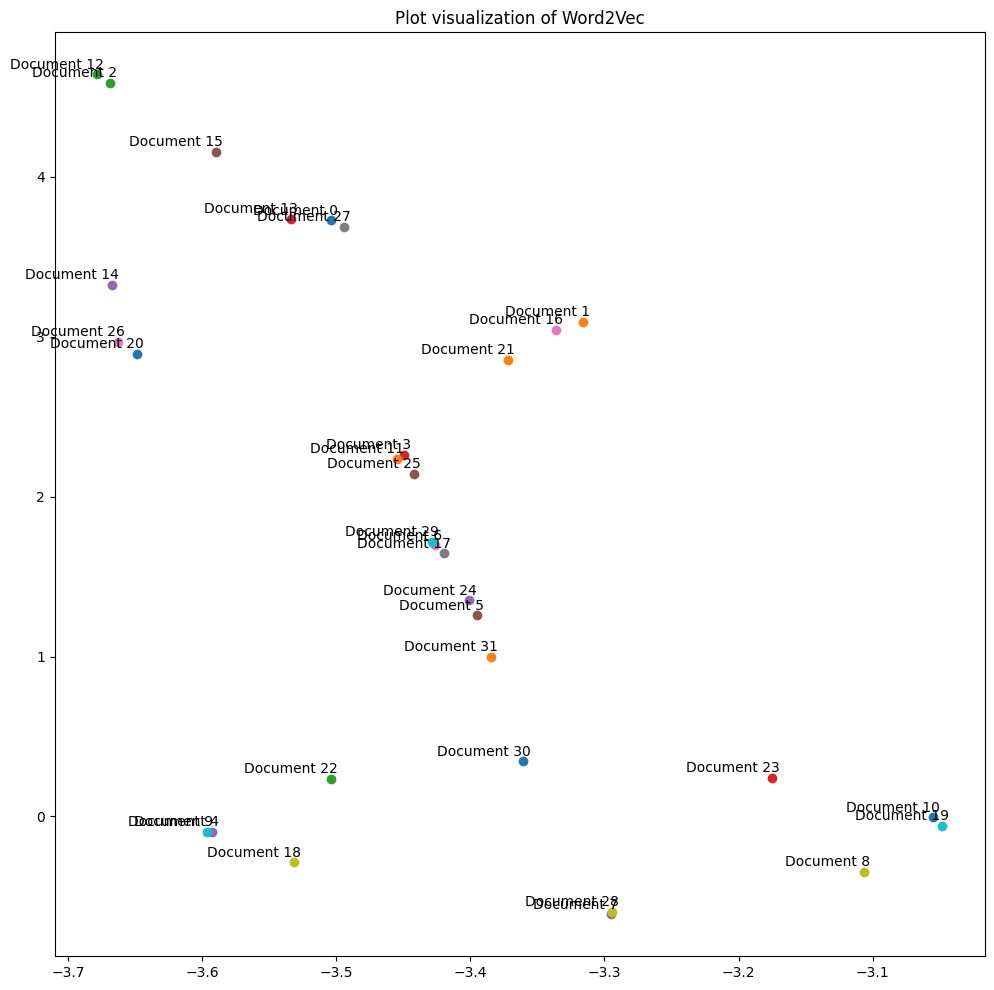

In [ ]:
tsne_plot(w2v_model, w2v_document_vectors, caption="Plot visualization of Word2Vec")

**Question 2.2.1 - Similarity in Word2Vec**

Calculate the 3 most similar papers (using cosine similarity) using the embedding for 5 random documents

In [ ]:
def get_similar_docs(doc_ids, doc_vectors):
  similar_docs = []
  for i in doc_ids:
    cosine_score = []
    for j in range(0,32):
      if j != i:
        score = np.dot(doc_vectors[i].squeeze(), doc_vectors[j].squeeze()) / (np.linalg.norm(doc_vectors[i].squeeze()) * np.linalg.norm(doc_vectors[j].squeeze()))
        cosine_score.append((score, j))

    cosine_score.sort(reverse=True)
    similar_docs.append(cosine_score[:3])

  return similar_docs

In [ ]:
doc_ids = [0, 17, 10, 7, 29]
similar_docs = get_similar_docs(doc_ids, w2v_document_vectors)

for i, score in enumerate(similar_docs):
  print(f"\n{docs[i]} \n")
  print(f"Most similar documents: {score}")
  print("\n\n")



Research Article
Heat Production and RF Detection during Cathodic Polarization of
Palladium in 0.1 M LiOD
The study of the Fleischmann–Pons Effect (FPE), i.e. the production of excess power production during electrochemical loading
of deuterium in palladium (in the past labeled cold fusion) has had a notably multidisciplinary character, involving solid state and
nuclear physics, material science, electrochemistry and other ﬁelds. Correlations between the material status and the occurrence of
the effect as well as some changes in the electrochemical interface status have been observed. Although during the last two decades,
in several calorimetric experiments the effect was observed to be well above the measurement uncertainty, the mechanism producing
the excess power is not completely understood. So far, the lack of reproducibility has been responsible for the absence of a clear
explanation of the phenomenon based on experimental apparatus designed to enhance the spectrum of informatio

**Question 2.1.2 - Embeddings using Doc2Vec**

In this step we convert the documents to vectors using the Doc2Vec model

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [ ]:
def get_d2v_model(document_vectors):
  model = Doc2Vec(vector_size=20, min_count=2, epochs=50)
  tagged_data = [TaggedDocument(words=sentences, tags=[str(i)]) for i, sentences in enumerate(clean_docs)]

  model.build_vocab(tagged_data)

  model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

  return model

In [ ]:
def get_d2v_doc_vectors(model, document_vectors):
  return [model.infer_vector(sentences) for sentences in clean_docs]

In [ ]:
d2v_model = get_d2v_model(document_vectors=clean_docs)

In [ ]:
d2v_document_vectors = get_d2v_doc_vectors(d2v_model, clean_docs)

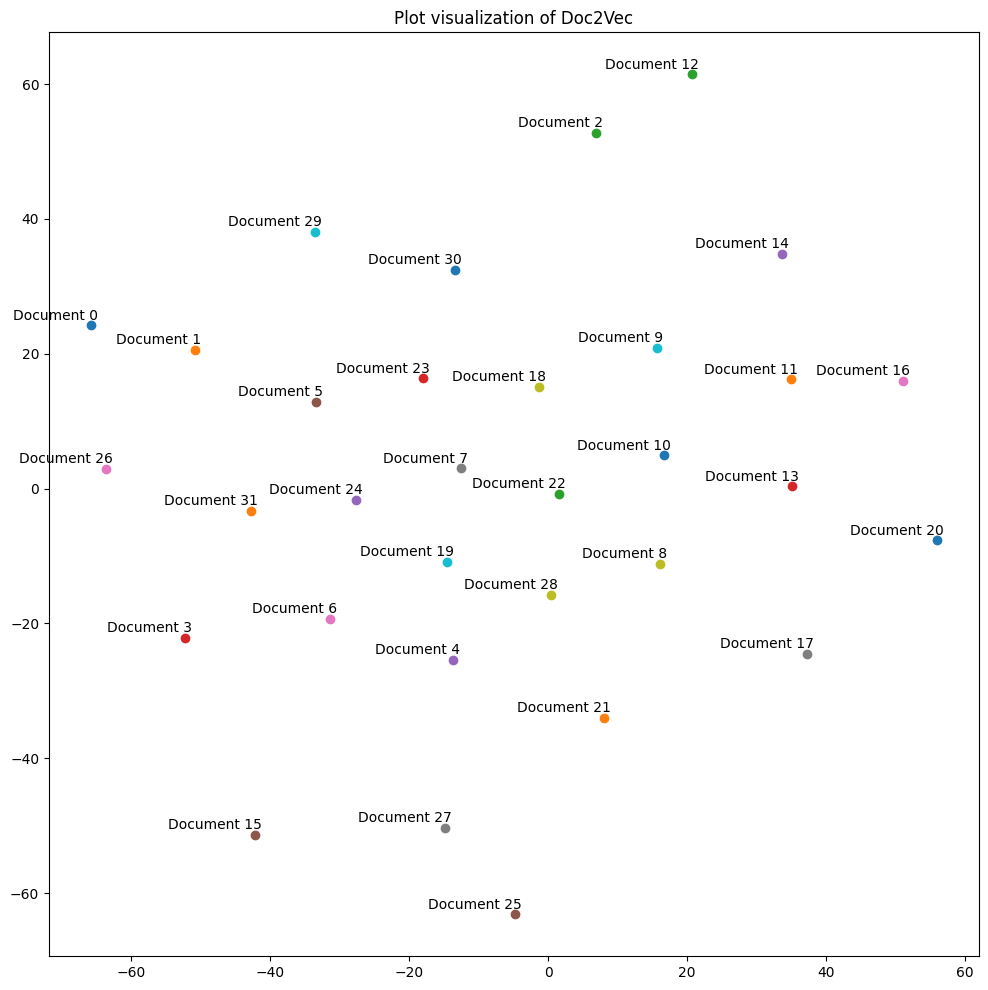

In [ ]:
tsne_plot(d2v_model, d2v_document_vectors, caption="Plot visualization of Doc2Vec")

**Question 2.2.2 - Similarity in Word2Vec**

Calculate the 3 most similar papers (using cosine similarity) using the embedding for 5 random documents

In [ ]:
doc_ids = [0, 17, 10, 7, 29]
similar_docs = get_similar_docs(doc_ids, d2v_document_vectors)

for i, score in enumerate(similar_docs):
  print(f"\n{docs[i]} \n")
  print(f"Most similar documents: {score}")
  print("\n\n")


Research Article
Heat Production and RF Detection during Cathodic Polarization of
Palladium in 0.1 M LiOD
The study of the Fleischmann–Pons Effect (FPE), i.e. the production of excess power production during electrochemical loading
of deuterium in palladium (in the past labeled cold fusion) has had a notably multidisciplinary character, involving solid state and
nuclear physics, material science, electrochemistry and other ﬁelds. Correlations between the material status and the occurrence of
the effect as well as some changes in the electrochemical interface status have been observed. Although during the last two decades,
in several calorimetric experiments the effect was observed to be well above the measurement uncertainty, the mechanism producing
the excess power is not completely understood. So far, the lack of reproducibility has been responsible for the absence of a clear
explanation of the phenomenon based on experimental apparatus designed to enhance the spectrum of informatio

**Question 2.2 - Similarity Comparisions**

Word2vec ```(min_count=6, vector_size=100, epochs=50)```
```
0 [(0.99984914, 1), (0.9998327, 6), (0.99980533, 26)]
17 [(0.9998421, 13), (0.99980986, 27), (0.99973106, 2)]
10 [(0.9998444, 13), (0.99983484, 8), (0.9997717, 11)]
7 [(0.9998166, 6), (0.99980927, 4), (0.99977946, 0)]
29 [(0.9997995, 28), (0.9997931, 30), (0.9995673, 1)]
```

Doc2vec
```
0 [(0.95825624, 1), (0.83267415, 7), (0.8172781, 6)]
17 [(0.70169884, 18), (0.6927954, 20), (0.6547136, 10)]
10 [(0.9268935, 8), (0.8606489, 9), (0.8422788, 18)]
7 [(0.9396712, 4), (0.9090893, 6), (0.89468586, 31)]
29 [(0.87092674, 28), (0.7706704, 30), (0.76955, 23)]
```


## Word Embeddings (Word2Vec) Anaysis using cosine similarity between documents.

- **doc1: doc2 < doc7 < doc 27** -
We can clearly see that results for doc1, results in relevant documents.
doc18: doc14 < doc28 < doc3 := We can see that groupings are relevant, but the ordering is odd and most similar document has very less common compared to other choices.

- **doc11: doc14 < doc9 < doc12**
The groupings are relevant, the top two most similar docs are good, but the third doc has very less similarity.

- **doc8: doc7 < doc5 < doc1**
The groups are relavant, and there are less flaws.

- **doc29: doc28, doc30, doc1**
The grouping is relevant regarding Palladium electrolysis and transmutation,
except one doc which talks only about heat generation during electrolysis.

### **doc1: doc2 < doc7 < doc 27.**
- doc1 -> Heat detection during electrochemical process on Palladium node, related to Fleischmann–Pons Effect. Detection of RF signal emission.
- doc2 -> A summary and analysis of electro magnetic emission in a certain frequency range, during heat generation of electro-chemical reaction between Palladium and Deutirium.
- doc7 -> Heat Generation during electrolyis of Palladium and Deutirium.
- doc27 -> Transumation of condensed matter involved during Flesichmann-Pons Effect of Palladium and Deutirium.

**Notes**: We can see that doc1 is mainly related to radio frequency and heat generation in FPE phenomenon. The doc2 which had the highest correlation
was mainly related to Radio Frequency analysis of FPE during heat generation of PFE, and cosine similarity was able to capture both the effects,
ans suggest similar paper. doc7 was related to just heat generation during electrolyis of Pd and H2, it was only able to capture one aspect of doc1.
The doc27, mainly talked about transmutation of condensed matter, which was completly different, only common thing was FPE of Pd and Deutirium.


### **doc18: doc14 < doc28 < doc3.**
- doc18 -> Plasma generation using Ni-Foil chathodic electrolysis. Study transmultation, hole burned and heat during HHP of electrode.
- doc14 -> Study of three experiments, one is Palladium and D20, second is electron beam irradiation and ion beam bombardment on Titanium deuteride.
- doc28 -> LENR on Ni-H system, using Ni and cathode and Platinum as anode, study of transmutation during electrolysis.
- doc3 -> Palladium Titanium electorlysis and study heat and transmutation during this process.

**Notes:** We can see that the doc18 talks about plasma generation and its study of transumations and hole burned through heat generation. the doc14
just talks about electroysis, electron beam generation and ion beam bombardment, which does match much of doc18. The doc28 has the highest
similarity as the talks about Ni involved in electrolyis and study of transmutation. The doc3, is similar because of study of transmutation during
Pd electrolysis.


### **doc11: doc14 < doc9 < doc12**
- doc11: Talks about application of these two techniques on thin foils: focused ion beam and nano-identation.
- doc14 -> Study of three experiments, one is Palladium and D20, second is electron beam irradiation and ion beam bombardment on Titanium deuteride.
- doc9 -> Description about a new Ion-beam system in Russia, that can be used for LENR experiment.
- doc12 -> Electron beam excitation of Palladium and Titanium, charged particle emmision during LENR in Deutirium system.

**Notes**: The doc11 mainly talks about ion beam and nono-identation, the doc14 correctly talks about multiple experiments and ion beam bombardment
on titanium. The doc9 talks about ion beam system of a system in Russia and doc12 has the least similar and talks about electron beam instead of
ion beam.

### **doc8: doc7 < doc5 < doc1**
- doc8 -> study of heat generation in PFE, heat generation, onset of current density using Palladium cathode.
- doc7 -> Heat Generation during electrolyis of Palladium and Deutirium
- doc5 -> Heat generation and nuclear ash in Palladium electrolyiss.
- doc1 -> Heat detection during electrochemical process on Palladium node, related to Fleischmann\-Pons Effect. Detection of RF signal emission.

**Notes:** All the docs are related to heat generation during Palladium electrolysis.


### **doc29: doc28, doc30, doc1**
- doc29 - Study of Transmutation and inertness of Palladium.
- doc28 -> LENR on Ni-H system, using Ni and cathode and Platinum as anode, study of transmutation during electrolysis.
- doc30 -> Study and transmutation during LENR and its correlation to abundance of elements on earth's crust.
- doc1 -> Heat detection during electrochemical process on Palladium node, related to Fleischmann Pons Effect. Detection of RF signal emission.

**Notes:** The grouping is good except document1, which does not talk about transmutation.

**Question 3 - Dimensionality Reduction**

Since the input embeddings are often high in dimensionality, clustering becomes difficult due to the curse of dimensionality.

Applying PCA/Incremental PCA dimensionality reduction on our documents

In [ ]:
from sklearn.decomposition import PCA, IncrementalPCA     # inital reduction
import numpy as np                                        # array handling

In [ ]:
def reduce_dimensions(doc_vectors, dimensions):
    num_dimensions = dimensions  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(doc_vectors)

    # reduce using t-SNE
    pca = PCA(n_components=num_dimensions)
    return pca.fit_transform(vectors)

In [ ]:
w2v_reduced_vectors = reduce_dimensions(w2v_document_vectors, 30)

In [ ]:
print(len(w2v_reduced_vectors))
print(w2v_reduced_vectors[0].shape[0])

32
30


**Question 4 - Clustering**

Cluster the reduced embeddings into groups of similar embeddings. We use K-Means clustering on the Word2Vec trained word vectors.

In [ ]:
from sklearn.cluster import KMeans

In [80]:
def plot_elbow(k_means_data, topic):
  wcss = []
  for i in range(1, 11):
      kmeans = KMeans(n_clusters = i, n_init='auto', random_state = 0)
      kmeans.fit(k_means_data)
      wcss.append(kmeans.inertia_)

  plt.figure(figsize=(7,7))
  plt.plot(range(1, 11), wcss)
  plt.xlabel('Number of clusters')
  plt.ylabel('Sum of Squared distance from centroid')
  plt.title(f"Finding the elbow for clustering - {topic}")
  plt.show()

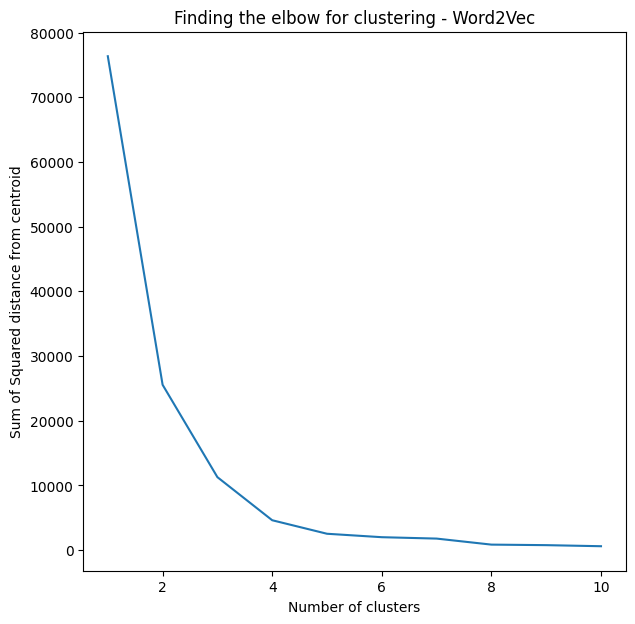

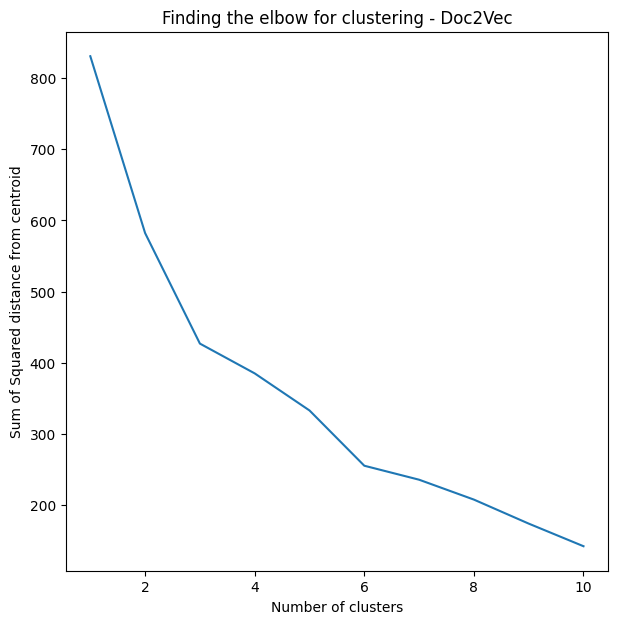

In [81]:
plot_elbow(w2v_reduced_vectors, "Word2Vec")
print("\n")
plot_elbow(d2v_document_vectors, "Doc2Vec")

**Elbow Method**

At k = 5, we observe that the graph becomes parallel to the x-axis.
Hence the optimal no. of clusters is 5

In [ ]:
total_clusters = 5

In [ ]:
def cluster(data, num_clusters):
  kmeans = KMeans(n_clusters = num_clusters, n_init='auto', random_state = 0)
  return kmeans.fit(data)

In [ ]:
cluster_info = cluster(w2v_reduced_vectors, total_clusters)
cluster_info.labels_

array([4, 2, 0, 3, 1, 3, 3, 1, 1, 1, 1, 3, 0, 4, 2, 4, 2, 3, 1, 1, 2, 2,
       1, 1, 3, 3, 2, 4, 1, 3, 1, 3], dtype=int32)

**Question 4a - Representative documents**

In [ ]:
from sklearn.utils.discovery import itemgetter

In [ ]:
def get_representative_documents(clusters, documents, document_vectors, cluster_count):
  labels = clusters.labels_
  centroids = clusters.cluster_centers_
  clustered_docs = [[] for i in range(0, cluster_count)]

  for i in range(0, len(documents)):
    dist = np.linalg.norm(document_vectors[i] - centroids[labels[i]])
    clustered_docs[labels[i]].append((documents[i], dist))

  rep_docs = []
  for i in range(0, cluster_count):
    clustered_docs[i].sort(key=itemgetter(1))
    rep_docs.append(clustered_docs[i][:3])

  return rep_docs




In [ ]:
representative_docs = get_representative_documents(cluster_info, docs, w2v_reduced_vectors, total_clusters)

In [ ]:
for i in range(0, total_clusters):
  print("\n____________________")
  print(f"\nCluster Number - {i}")
  for doc, dist in representative_docs[i]:
    print(f"\n\nDocument: \n\n{doc}")


____________________

Cluster Number - 0


Document: 

RESEARCH INTO CHARACTERISTICS OF X-RAY EMISSION
LASER BEAMS FROM SOLID-STATE CATHODE MEDIUM OF
HIGH-CURRENT GLOW DISCHARGE
X-ray emissions ranging 1.2 – 3.0 keV with dose rate up to 1.0 Gy/s have been registered in
experiments with high-current Glow Discharge. The emissions energy and intensity depend on
the cathode material; the kind of plasma-forming gas; and the discharge parameters. The
experiments were carried out on the high-current glow discharge device using D2, H2, Kr and Xe
at pressure up to 10 Torr, as well as cathode samples made from Al, Sc, Ti, Ni, Nb, Zr, Mo, Pd,
Ta, W, Pt, at current up to 500 mA and discharge voltage of 500-2500 V. Two emission modes
were revealed under the experiments: 1. Diffusion X-rays was observed as separate X-ray bursts
(up to 5×105 bursts a second and up to 106 X-ray quanta in a burst); 2. X-rays in the form of laser
microbeams (up to 104 beams a second and up to 1010 X-ray of quanta in a 

**Question 4b - Visualization of clusters**

1. Reduce the vectors from 30 dimensions to 2 dimensions to plot
2. Plot the vectors and the corresponding cluster centers

In [ ]:
def reduce_to_2_dimensions(document_vectors):
  vectors = np.asarray(document_vectors)

  # reduce using pca
  pca = PCA(n_components=2, random_state=0)
  vectors = pca.fit_transform(vectors)
  return vectors

In [ ]:
plottable_vectors = reduce_to_2_dimensions(w2v_reduced_vectors)

In [ ]:
def plot_clusters(vectors, clusters, cluster_count):
  labels = clusters.labels_

  plt.figure(figsize=(10, 10))

  clustered_vectors = [[] for i in range(0, cluster_count)]

  for i in range(0, len(vectors)):
    clustered_vectors[labels[i]].append(vectors[i])


  for i in range(0, len(clustered_vectors)):
    cluster = np.asarray(clustered_vectors[i])
    plt.scatter(cluster[:, 0], cluster[:, 1], s=60, label = f"Cluster {i}")

  centroids = reduce_to_2_dimensions(clusters.cluster_centers_)
  plt.scatter(centroids[:, 0], centroids[:, 1], s = 100, c='black', label = 'Centroids')
  plt.legend()
  plt.title("Clustered Documents")
  plt.show()


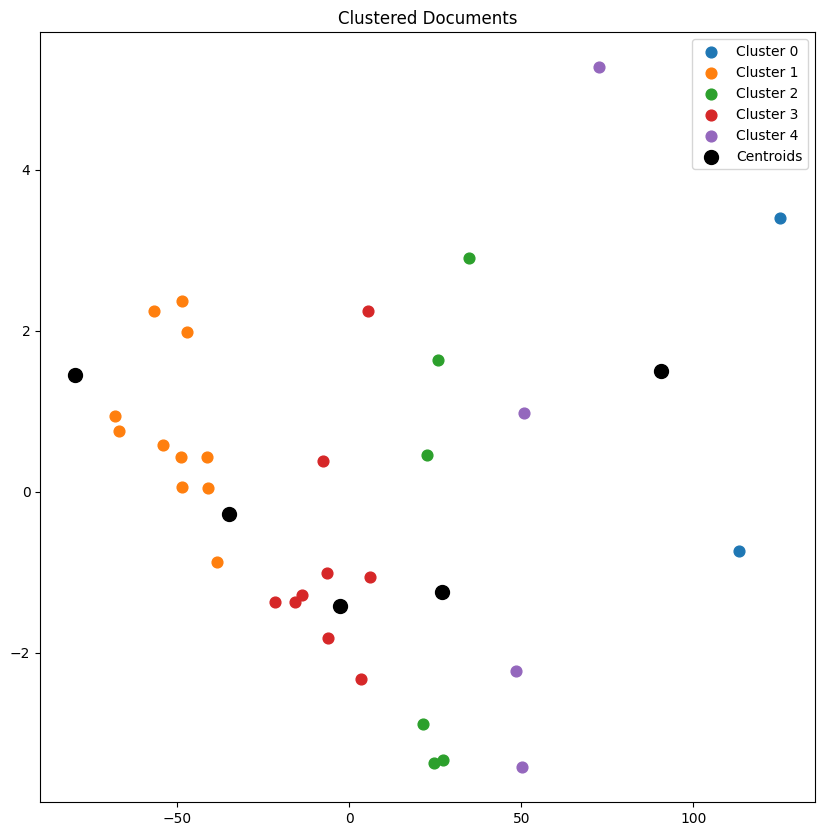

In [ ]:
plot_clusters(plottable_vectors, cluster_info, total_clusters)

**Question 5 - Class based TF-IDF**

Applying TF-IDF on a cluster level

1. Merge all documents in a single cluster
2. Perform TF-IDF on word corpus
3. Get 6 keywords per cluster

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

In [ ]:
def get_cluster_docs(clusters, documents):
  labels = clusters.labels_
  centroids = clusters.cluster_centers_

  clustered_docs = [[] for i in range(0, len(centroids))]

  for i in range(0, len(documents)):
    clustered_docs[labels[i]] += documents[i]

  return clustered_docs

In [ ]:
clustered_docs = get_cluster_docs(cluster_info, clean_docs)

In [ ]:
count_vectorizer = CountVectorizer()
cluster_sentences = [' '.join(doc) for doc in clustered_docs]
word_count = count_vectorizer.fit_transform(cluster_sentences)

tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf_transformer.fit(word_count)

TfidfTransformer()

In [ ]:
#tfidf
tf_idf_vectors = tfidf_transformer.transform(word_count)
feature_names = count_vectorizer.get_feature_names_out()

In [ ]:
def get_keywords(tf_idf_vectors, feature_names):
  keyword_list = []
  for i in range(0, total_clusters):
    document_vector = tf_idf_vectors[i]
    tf_idf_dataframe = pd.DataFrame(document_vector.T.todense(), index = feature_names, columns = ["tf_idf"])
    keywords = tf_idf_dataframe.sort_values(by = ["tf_idf"], ascending = False)[:6]
    keyword_list.append(keywords.index.tolist())

  return keyword_list

In [ ]:
keywords = get_keywords(tf_idf_vectors, feature_names)

In [ ]:
# Output for Question 5
cluster_details_list = []

for i in range(0, total_clusters):
  rep_docs = [doc for doc, dist in representative_docs[i]]
  cluster_details_list.append((i, rep_docs, keywords[i]))

In [ ]:
# import the pandas module
import pandas as pd

# create three lists for cluster_ids, rep_docs, and keywords
cluster_ids = [(cluster + 1) for cluster, rep, keywords in cluster_details_list]
rep_docs = [rep for cluster, rep, keywords in cluster_details_list]
keywords = [keyword for cluster, rep, keyword in cluster_details_list]

# create a dictionary with the three lists
dict = {'Cluster_id': cluster_ids, 'Representative Documents': rep_docs, 'Keywords': keywords}

# create a Pandas DataFrame from the dictionary
df = pd.DataFrame(dict)

# write the DataFrame to a CSV file
df.to_csv('cluster_info.csv')

In [ ]:
cluster_details_list

[(0,
  ['RESEARCH INTO CHARACTERISTICS OF X-RAY EMISSION\nLASER BEAMS FROM SOLID-STATE CATHODE MEDIUM OF\nHIGH-CURRENT GLOW DISCHARGE\nX-ray emissions ranging 1.2 – 3.0 keV with dose rate up to 1.0 Gy/s have been registered in\nexperiments with high-current Glow Discharge. The emissions energy and intensity depend on\nthe cathode material; the kind of plasma-forming gas; and the discharge parameters. The\nexperiments were carried out on the high-current glow discharge device using D2, H2, Kr and Xe\nat pressure up to 10 Torr, as well as cathode samples made from Al, Sc, Ti, Ni, Nb, Zr, Mo, Pd,\nTa, W, Pt, at current up to 500 mA and discharge voltage of 500-2500 V. Two emission modes\nwere revealed under the experiments: 1. Diffusion X-rays was observed as separate X-ray bursts\n(up to 5×105 bursts a second and up to 106 X-ray quanta in a burst); 2. X-rays in the form of laser\nmicrobeams (up to 104 beams a second and up to 1010 X-ray of quanta in a beam, angular\ndivergence was up to 

**Question 6 - Topic Representation**

Use the keywords obtained from the previous question to generate better topic representation using Chat-GPT APIs

In [ ]:
import openai
import json
import time

# create an open ai account
# in personal section, create your api key
# few requests per minute, for free users.
openai.api_key = 'INSERT_YOUR_API'

In [ ]:
def get_topics(keyword_list):
  topics = []
  for keywords in keyword_list:
    message = "[" + ", ".join(keywords) + "]"

    prompt = [ {"role": "system", "content":
              "Give the summary of the document using mentioned list of keywords."} ]
    if message:
        prompt.append(
            {"role": "user", "content": message},
        )
        chat = openai.ChatCompletion.create(
            model="gpt-3.5-turbo", messages=prompt
        )
    topic = chat.choices[0].message.content
    topics.append(topic)
    print(topic)
    time.sleep(30)

  return topics

In [ ]:
topics = get_topics(keywords)

The document discusses the discharge of radiation in a medium through the use of x-rays and a cathode burst.
The document discusses various topics such as heat, electrolysis, plasma, isotopes, surface, and transmutation. It likely covers how these concepts are related and their implications.
The document discusses the reaction between deuterons (nuclei of deuterium) and the formation of the dineutron. It also explores the heat generated during this reaction and the potential energy involved.
The document discusses the model of heat transmutation and its effects on excess heat resistance in a high-heat producing (HHP) system.
This document discusses an experiment on the peak beam effect in palladium electrolysis. It explores the impact of beam experiments on the electrolysis process and specifically focuses on the effect on palladium.


### Question to Answer
1. What is the curse of dimensionality? [10 points]

  The curse of dimensionality refers to the phenomenon in which the volume of the data space increases exponentially with the number of features or dimensions. In other words, as you add more features to your dataset, the data points become increasingly sparse in the high-dimensional space.It leads
  to following problems
  - Increased computational complexity
  - Increased data requirements
  - Decreased performance of machine learning algorithms.
  - Overfitting
  - Difficulties in visualization


2. Explain in brief the embedding techniques you have used. [10 points]

  We have used two embeddings, these are Word2Vec and Doc2Vec.
  - Word2Vec: The main idea behind Word2Vec is to represent words as dense vectors in such a way that words with similar meanings are close to each other in the vector space. These dense vector representations capture semantic relationships between words and can be used for various NLP tasks, such as text classification, language translation, and sentiment analysis. There are two main paradigms for this method 1. Continuous bag of words and 2. Skip gram

  - Doc2Vec: Doc2Vec, also known as paragraph embeddings, is an extension of the Word2Vec model that learns fixed-length vector representations for variable-length pieces of text, such as sentences, paragraphs, or entire documents. While Word2Vec learns vector representations for individual words, Doc2Vec learns vector representations for entire documents, preserving the semantic meaning and context of the entire text.


3. From the two embedding models used, which model performs better? Why do you think so? [10 points]

  We feel Word2Vec performs better compared to Doc2Vec. We feel this is mainly because the amount of text we abstracted from title and abstract is less compared to the capabilities of doc2vec, the papers with small titles and abstract gave pretty small correlation during cosine similarity. The Word2Vec just compares the word similarity and works well in small data.

  The other reason we decided to go with Word2Vec embedding model is because the Elbow method for K-Means clustering was more accurate in Word2Vec embedding model.